In [1]:
#| hide
%load_ext autoreload
%autoreload 2

# Analyzing the trained models
> Access and interpret the models after fitting

## Data setup

In [2]:
from mlforecast.utils import generate_daily_series

In [3]:
series = generate_daily_series(10)
series.head()

,unique_id,ds,y
0,id_0,2000-01-01,0.322947
1,id_0,2000-01-02,1.218794
2,id_0,2000-01-03,2.445887
3,id_0,2000-01-04,3.481831
4,id_0,2000-01-05,4.191721


## Training

Suppose that you want to train a linear regression model using the day of the week and lag1 as features.

In [4]:
from sklearn.linear_model import LinearRegression

from mlforecast import MLForecast

In [5]:
fcst = MLForecast(
    freq='D',
    models={'lr': LinearRegression()},
    lags=[1],
    date_features=['dayofweek'],
)

In [6]:
fcst.fit(series)

MLForecast(models=[lr], freq=<Day>, lag_features=['lag1'], date_features=['dayofweek'], num_threads=1)

What `MLForecast.fit` does is save the required data for the predict step and also train the models (in this case the linear regression). The trained models are available in the `MLForecast.models_` attribute, which is a dictionary where the keys are the model names and the values are the model themselves.

In [7]:
fcst.models_

{'lr': LinearRegression()}

## Inspect parameters

We can access the linear regression coefficients in the following way:

In [8]:
fcst.models_['lr'].intercept_, fcst.models_['lr'].coef_

(3.2476337167384406, array([ 0.19896416, -0.21441331]))

## SHAP

In [9]:
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


### Training set

If you need to generate the training data you can use `MLForecast.preprocess`.

In [10]:
prep = fcst.preprocess(series)
prep.head()

,unique_id,ds,y,lag1,dayofweek
1,id_0,2000-01-02,1.218794,0.322947,6
2,id_0,2000-01-03,2.445887,1.218794,0
3,id_0,2000-01-04,3.481831,2.445887,1
4,id_0,2000-01-05,4.191721,3.481831,2
5,id_0,2000-01-06,5.395863,4.191721,3


We extract the X, which involves dropping the info columns (id + times) and the target

In [11]:
X = prep.drop(columns=['unique_id', 'ds', 'y'])
X.head()

,lag1,dayofweek
1,0.322947,6
2,1.218794,0
3,2.445887,1
4,3.481831,2
5,4.191721,3


We can now compute the shap values

In [12]:
X100 = shap.utils.sample(X, 100)
explainer = shap.Explainer(fcst.models_['lr'].predict, X100)
shap_values = explainer(X)

ExactExplainer explainer: 2367it [00:10, 32.35it/s]                           


And visualize them

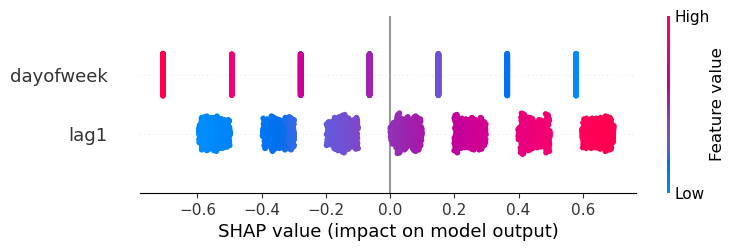

In [13]:
shap.plots.beeswarm(shap_values)

### Predictions

Sometimes you want to determine why the model gave a specific prediction. In order to do this you need the input features, which aren't returned by default, but you can retrieve them using a callback.

In [14]:
from mlforecast.callbacks import SaveFeatures

In [15]:
save_feats = SaveFeatures()
preds = fcst.predict(1, before_predict_callback=save_feats)
preds.head()

,unique_id,ds,lr
0,id_0,2000-08-10,3.468643
1,id_1,2000-04-07,3.016877
2,id_2,2000-06-16,2.815249
3,id_3,2000-08-30,4.048894
4,id_4,2001-01-08,3.524532


You can now retrieve the features by using `SaveFeatures.get_features`

In [16]:
features = save_feats.get_features()
features.head()

,lag1,dayofweek
0,4.343744,3
1,3.150799,4
2,2.137412,4
3,6.182456,2
4,1.391698,0


And use those features to compute the shap values.

In [17]:
shap_values_predictions = explainer(features)

We can now analyze what influenced the prediction for `'id_4'`.

In [18]:
round(preds.loc[4, 'lr'], 3)

3.525

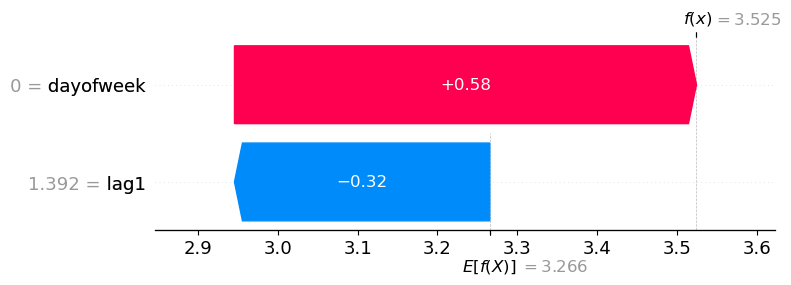

In [19]:
shap.plots.waterfall(shap_values_predictions[4])

## Other Model Diagnostics

Any framework specific tooling and third party package for model diagnostics can be applied to the model stored in the `MLForecast.models_`  dictionary. To illustrate this, two examples will be presented here:
1) plot the feature importance of fitted CatboostRegressor and LGBMRegressor models
2) display the tree of a LGBMRegressor

### Display feature importance for LightGBM and Catboost

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 262
[LightGBM] [Info] Number of data points in the train set: 2366, number of used features: 2
[LightGBM] [Info] Start training from score 3.252315


,catboost feature_importance
lag1,98.958633
dayofweek,1.041367


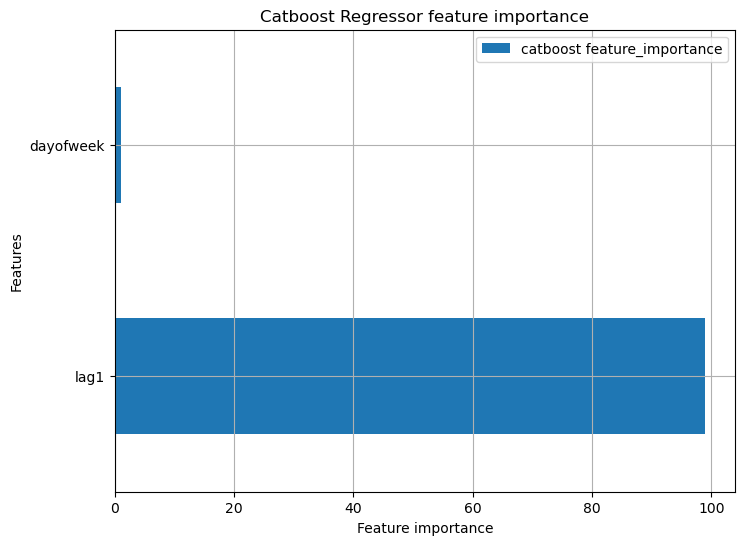

In [20]:
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import pandas as pd
import matplotlib.pyplot as plt

fcst = MLForecast(
    freq='D',
    models={'catboost_reg': CatBoostRegressor(logging_level='Silent'),
            'lgbm_reg': LGBMRegressor()},
    lags=[1],
    date_features=['dayofweek'],
)
fcst.fit(series)

feature_importance_cat = pd.DataFrame(fcst.models_.get('catboost_reg').get_feature_importance(type='PredictionValuesChange'),
                                  index=fcst.preprocess(series).drop(columns=['unique_id', 'ds', 'y']).columns,
                                  columns= ["catboost feature_importance"])

feature_importance_cat.plot.barh(grid = True, figsize = (8,6),title = "Catboost Regressor feature importance", ylabel = "Features",xlabel = "Feature importance")
feature_importance_cat

<Axes: title={'center': 'LightGBM Regressor feature importance'}, xlabel='Feature importance', ylabel='Features'>

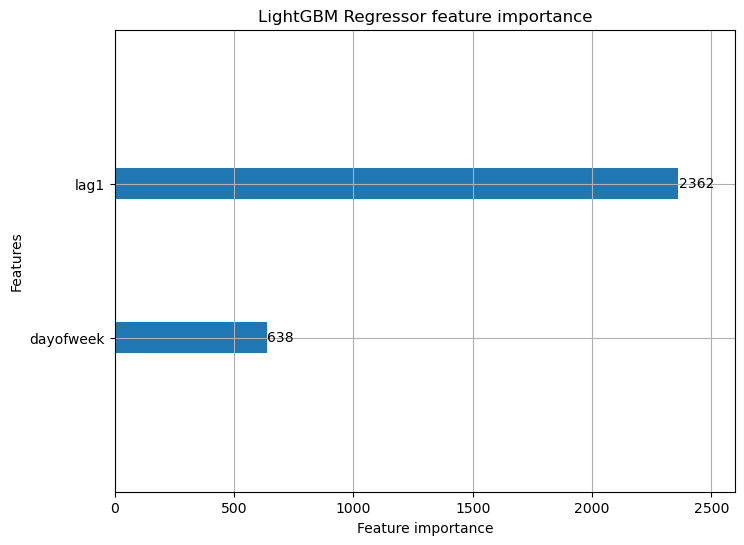

In [21]:
from lightgbm import plot_importance
plot_importance(fcst.models_.get('lgbm_reg'), grid = True, figsize = (8,6),title = "LightGBM Regressor feature importance")

### Dipslay the LightGBM tree

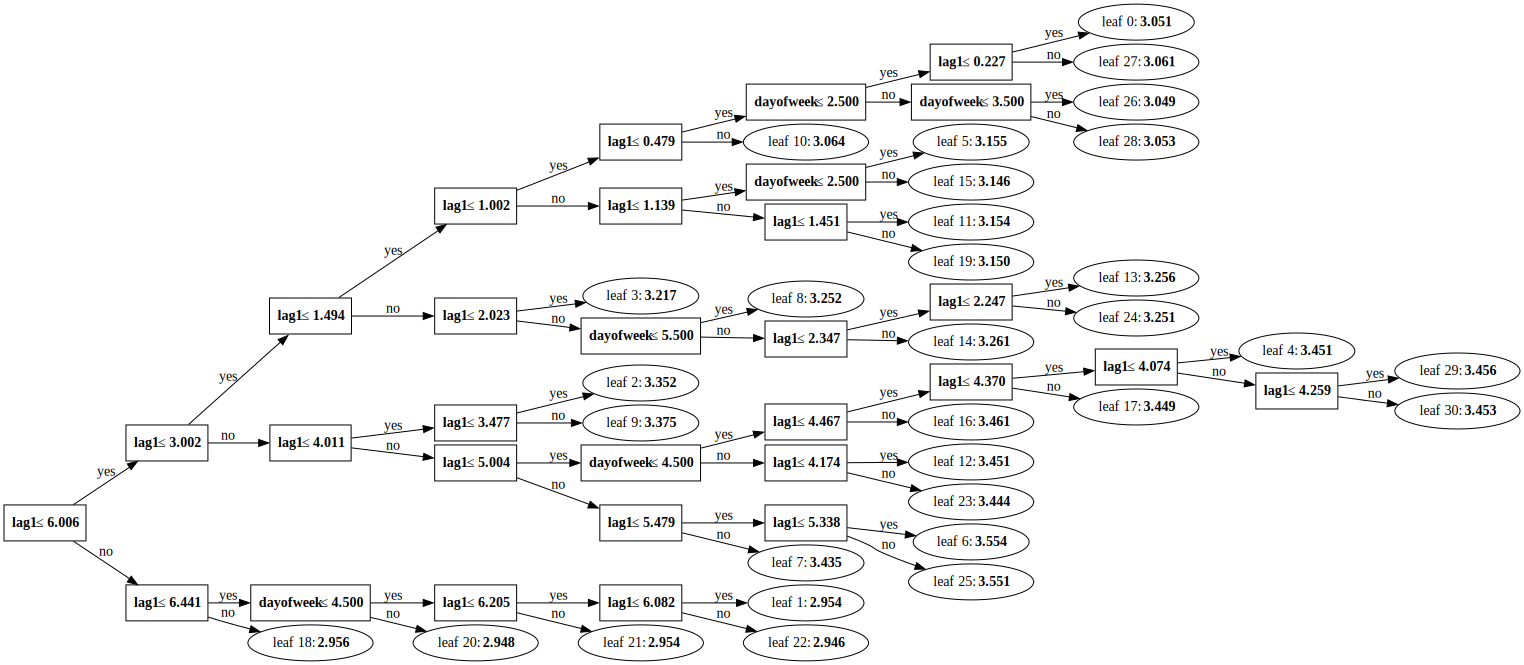

In [22]:
from lightgbm import create_tree_digraph
create_tree_digraph(fcst.models_.get('lgbm_reg'))